In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing   
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer # melakukan transformasi (fit transform = transformer)
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectPercentile

# Utilities
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils.testing import ignore_warnings

In [2]:
df = pd.read_csv('8. adult.csv')
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [3]:
df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [4]:
df.replace("?",np.nan,inplace=True)

In [5]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

PreProcessing Scheme :
* Data = adult
* Target = Income

Preprocess =
1. Missing Value    = Simple Imputer with constant
2. One Hot Encoding = relationship, race, sex
3. Binary Encoding  = workclass, marital.status, occupation, native.country
4. Ordinal Encoding = education(already encoded = education.num)
5. No Treatment     = numerical feature
6. Drop             = fnlwgt,education

Random_state = 10, Data Splitting = 70:30

1. Feature Selection = Select Percentile
2. Model             = Logistic Regression(max itteration = 1000, solver liblinear, C 10) & DecisionTreeClassifier

## Preprocessing

In [6]:
pipeline_binary = Pipeline([
    ('simple imputer',SimpleImputer(strategy='constant',fill_value='NC')),
    ('Binary encoding',ce.BinaryEncoder())
])

In [7]:
transformer = ColumnTransformer([
    ('one hot',OneHotEncoder(drop='first'),['relationship','race','sex']),
    ('binary',pipeline_binary,['workclass','marital.status','occupation','native.country']),
],remainder='passthrough')

## Data Splitting

In [8]:
X = df.drop(['income','fnlwgt','education'],axis = 1)
y = np.where(df['income']=='>50K',1,0)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                stratify=y,
                                                random_state=10,
                                                test_size=0.3)

## Data Transform

In [10]:
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [11]:
X_train_prep=pd.DataFrame(X_train_prep)
X_test_prep=pd.DataFrame(X_test_prep)

In [12]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_Not-in-family', 'x0_Other-relative', 'x0_Own-child',
       'x0_Unmarried', 'x0_Wife', 'x1_Asian-Pac-Islander', 'x1_Black',
       'x1_Other', 'x1_White', 'x2_Male'], dtype=object)

In [13]:
transformer.transformers_[1][1]

Pipeline(steps=[('simple imputer',
                 SimpleImputer(fill_value='NC', strategy='constant')),
                ('Binary encoding', BinaryEncoder())])

In [14]:
transformer.transformers_[1][1]['Binary encoding'].get_feature_names()

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '3_5',
 '3_6']

In [15]:
feature = list(transformer.transformers_[0][1].get_feature_names())+transformer.transformers_[1][1]['Binary encoding'].get_feature_names()+['age','education_num','capital.gain','capital.loss','hours.per.week']

In [16]:
X_train_prep.columns=feature
X_test_prep.columns=feature

## Model Fitting and Evaluation

### Logistic Regression

In [17]:
log = LogisticRegression(max_iter=1000,solver='liblinear',C=10)
log.fit(X_train_prep,y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [18]:
y_pred = log.predict(X_test_prep)
accuracy_score(y_test,y_pred)

0.8526973078104207

### Decision Tree

In [19]:
k = range(1,30,1)
testing_accuracy = []
training_accuracy = []
score = 0

for i in k:
    tree = DecisionTreeClassifier(max_depth=i)
    tree.fit(X_train_prep,y_train)
    
    y_predict_train = tree.predict(X_train_prep)
    training_accuracy.append(accuracy_score(y_train,y_predict_train))
    
    y_predict_test  = tree.predict(X_test_prep)
    acc_score = accuracy_score(y_test,y_predict_test)
    testing_accuracy.append(acc_score)
    
    if score < acc_score:
        score = acc_score
        best_depth=i

In [20]:
score,best_depth

(0.8577131743269526, 10)

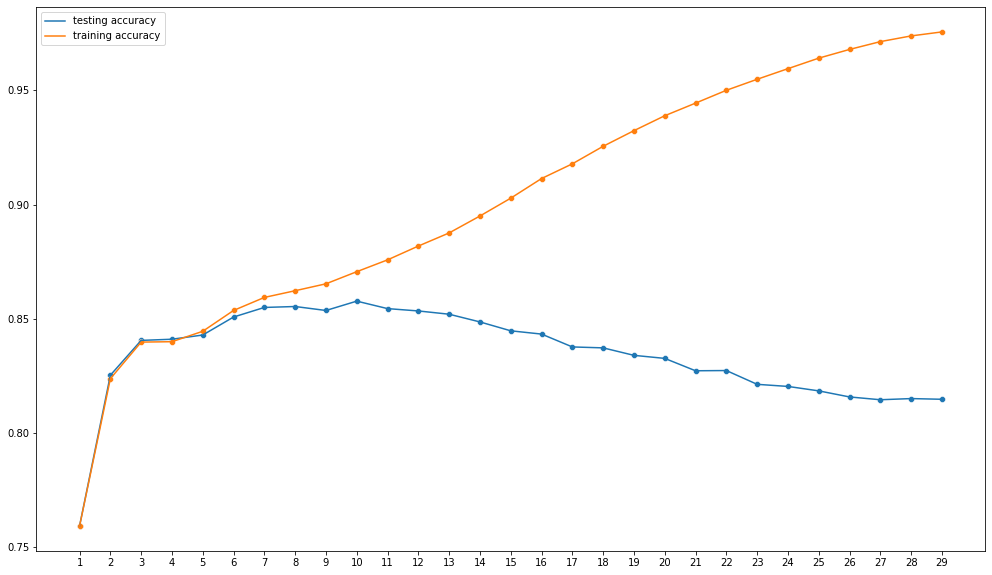

In [21]:
plt.figure(figsize = (17,10))
sns.lineplot(k,testing_accuracy)
sns.scatterplot(k,testing_accuracy)
sns.lineplot(k,training_accuracy)
sns.scatterplot(k,training_accuracy)
plt.legend(['testing accuracy','training accuracy'])
plt.xticks(list(k))
plt.show()

## Model Properties

In [22]:
importance_table = pd.DataFrame({'imp':tree.feature_importances_},index=feature)
a = importance_table.sort_values('imp',ascending=True)

<AxesSubplot:>

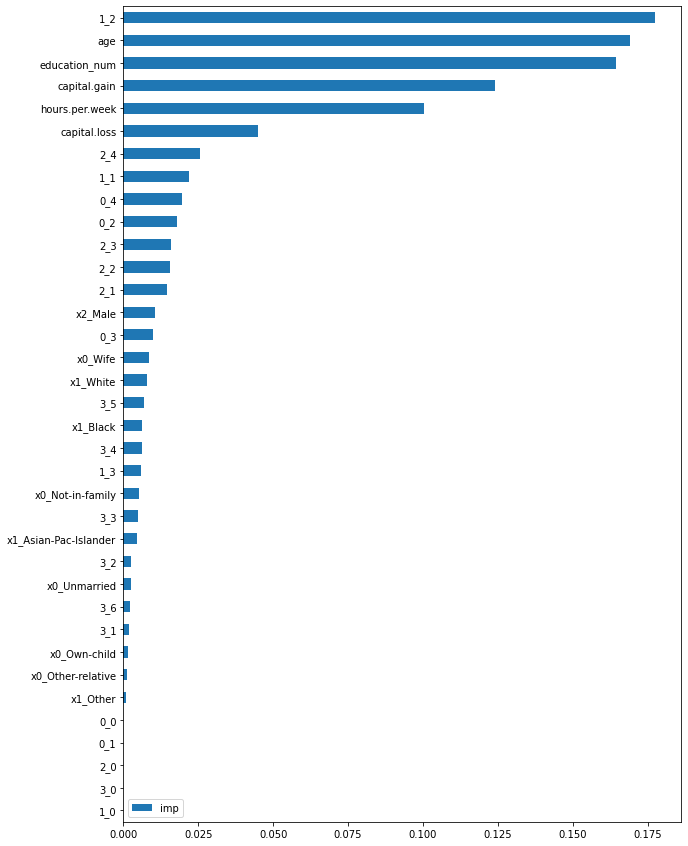

In [23]:
a.plot(kind='barh',figsize=(10,15))

important Feature :
* marital status
* age
* education num
* capital.gain
* hours per week

## Model Baru

Karena telah diketahui 5 feature yang paling berpengaruh terhadap model, maka kita coba menggunakan hanya 5 feature tersebut, apakah model akan mengalami kenaikan atau tidak

Membuat data frame baru agar tidak mengganggu data frame awal kedepannya apabila akan digunakan lagi

In [24]:
df_new = df.copy()
df_new

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [25]:
df_new = df_new[['marital.status','age','education.num','capital.gain','hours.per.week','income']]

In [26]:
df_new

,marital.status,age,education.num,capital.gain,hours.per.week,income
0,Widowed,90,9,0,40,<=50K
1,Widowed,82,9,0,18,<=50K
2,Widowed,66,10,0,40,<=50K
3,Divorced,54,4,0,40,<=50K
4,Separated,41,10,0,40,<=50K
...,...,...,...,...,...,...
32556,Never-married,22,10,0,40,<=50K
32557,Married-civ-spouse,27,12,0,38,<=50K
32558,Married-civ-spouse,40,9,0,40,>50K
32559,Widowed,58,9,0,40,<=50K


## Preprocessing 
* marital.status = binary encoding
* One Hot Encoding = Marital Status

In [27]:
binary_pipe = Pipeline([
    ('simple imputer',SimpleImputer(strategy='constant',fill_value='NC')),
    ('Binary encoding',ce.BinaryEncoder())
])

In [28]:
transformer = ColumnTransformer([
   ('binary',pipeline_binary,['marital.status']),
],remainder='passthrough')

## Data Splitting

In [29]:
X = df_new.drop(['income'],axis=1)
y = np.where(df_new['income']=='>50K',1,0)

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                stratify=y,
                                                random_state=10,
                                                test_size=0.3)

## Data transform

In [31]:
X_train_proc = transformer.fit_transform(X_train)
X_test_proc = transformer.fit_transform(X_test)

In [32]:
X_train_proc = pd.DataFrame(X_train_proc)
X_test_proc  = pd.DataFrame(X_test_proc) 

In [33]:
transformer.transformers_[0][1]['Binary encoding'].get_feature_names()

['0_0', '0_1', '0_2', '0_3']

In [34]:
features = list(transformer.transformers_[0][1]['Binary encoding'].get_feature_names())+['age','education.num','capital.gain','hours.per.week']

In [35]:
X_test_proc.columns = features
X_train_proc.columns = features

## Model Fitting and Evaluation

karena pada model awal didapat max depth terbaik = 10, pada model kali ini kita gunakan parameter yang sama seperti model awal yang menjadi acuan

In [36]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train_proc,y_train)

DecisionTreeClassifier(max_depth=10)

In [37]:
y_pred = tree.predict(X_train_proc)
accuracy_score(y_train,y_pred)

0.858020358020358

terdapat kenaikan walaupun tidak signifikan
* model awal  = 85.77
* model akhir = 85.80